In [1]:
import os
import pandas as pd
from utils import read_accs_from_folder
from utils import plot_acc_merged
import seaborn as sns
import matplotlib.pyplot as plt

ROOT = "./result-adaxeval"
model_names = [
    # "llm-jp-3-13b-exp1-multi-ja",
    "llm-jp-3-13b-exp1-multi-en_jstage",
    "llm-jp-3-13b-exp6-baseline",
    # "llm-jp-3-13b-exp6-multi-en_jstage-en2ja50",
    "llm-jp-3-13b-exp6-multi-en_jstage-en2ja100",
    # "llm-jp-3-13b-exp6-multi-ja-umls100-11",
    # "llm-jp-3-13b-exp6-multi-ja-umls100-11.repeat2",
    # "llm-jp-3-13b-exp6-mono-umls100-11",
    "llm-jp-3-13b-exp6-mono-syntax8",
    "llm-jp-3-13b-exp6-mono-syntax16",
    "llm-jp-3-13b-exp6-mono-syntax32",
    "llm-jp-3-13b-exp6-multi-ja-wordnet32",
    # "llm-jp-3-13b-exp1-multi-en_jstage",
    # "llm-jp-3-13b-exp1-ja-high_overlap",
    # "llm-jp-3-13b-exp1-ja-low_overlap",
    # "llm-jp-3-13b-exp2-multi",
]

namedicts = {
    # "llm-jp-3-13b-exp1-multi-ja": "0.5B Ja-Jstage",
    # "llm-jp-3-13b-exp1-ja-high_overlap": "High Token Freq",
    # "llm-jp-3-13b-exp1-ja-low_overlap": "Low Token Freq",
    # "llm-jp-3-13b-exp1-multi-en": "0.5B En-Pubmed",
    # "llm-jp-3-13b-exp1-multi-en_jstage": "0.5B En-Jstage",
    # "llm-jp-3-13b-exp2-multi": "0.5B Ja-Jstage &\n0.5B En-Pubmed",
    "llm-jp-3-13b-exp1-multi-en_jstage": "w/o Denoising",
    "llm-jp-3-13b-exp6-baseline": "Baseline w template",
    "llm-jp-3-13b-exp6-multi-en_jstage-en2ja100": "English UMLS 100%, Long instruction, 0505*2",
    "llm-jp-3-13b-exp6-multi-en_jstage-en2ja50": "English UMLS 50%, Long instruction, 0505*2",
    "llm-jp-3-13b-exp6-multi-ja-umls100-11": "Japanese UMLS 100%, Short instruction, 1010*1",
    "llm-jp-3-13b-exp6-multi-ja-umls100-11.repeat2": "Japanese UMLS 100%, Short instruction, 0505*2",
    "llm-jp-3-13b-exp6-mono-umls100-11": "UMLS 100%, Short instruction, 1010*1, Mono",
    "llm-jp-3-13b-exp6-mono-syntax8": "Syntax 8%, 0505*2, Mono",
    "llm-jp-3-13b-exp6-mono-syntax16": "Syntax 16%, 0505*2, Mono",
    "llm-jp-3-13b-exp6-mono-syntax32": "Syntax 32%, 0505*2, Mono",
    "llm-jp-3-13b-exp6-mono-wordnet32": "En-WordNet 32%, 0505*2, Mono",
    "llm-jp-3-13b-exp6-multi-ja-wordnet32": "Ja-WordNet 32%, 0505*2",
}

template = "prompt"
num_shot = 0

In [2]:
is_ood = False
delta_acc = False

dfs = []
for model_name in model_names:
    result_dir = os.path.join(ROOT, f"{model_name}_{template}_{str(num_shot)}-shot")
    df = read_accs_from_folder(result_dir, model_name, is_ood=is_ood, delta_acc=delta_acc, namedicts=namedicts)
    dfs.append(df)
df = pd.concat(dfs)

In [3]:
from matplotlib.ticker import FuncFormatter

def plot_acc_merged(eval_type, eval_task, eval_lang):
    _df = df[
        (df["task"] == eval_task) &
        (df["eval_type"] == eval_type) &
        (df["eval_lang"] == eval_lang)]
    _df = _df.rename(columns={"model_name": "Train Data", "eval_lang": "Eval Lang"})
    plt.figure(figsize=(8, 3), constrained_layout=True)
    sns.lineplot(
        data=_df, 
        x='iter_num', 
        y='acc', 
        # hue='task', 
        hue='Train Data', 
        markers=True,
        linewidth=2,
        # hue_order=['TrainEval-native', 'TrainEval-CLT'] if not is_ood else ['TrainEval-native-OOD', 'TrainEval-CLT-OOD'],
        # palette={'TrainEval-native': '#F9A037', 'TrainEval-CLT': '#3D7AB3', 'TrainEval-native-OOD': '#F9A037', 'TrainEval-CLT-OOD': '#3D7AB3'}
    )

    def thousands_formatter(x, pos):
        if x == 0: return '0'
        else:
            return f'{int(x / 1000)}K'

    plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.axvline(x=3841, color='red', linestyle='dotted', label='1st Epoch', linewidth=2)
    plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.title("MonoCPT and evaluate on same domain & languages")
    plt.xlabel("Iteration Number", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.ylim(0.5, 0.55)
    # plt.ylabel("Accuracy Difference to Baseline")
    plt.ylabel("Accuracy", fontsize=14)
        


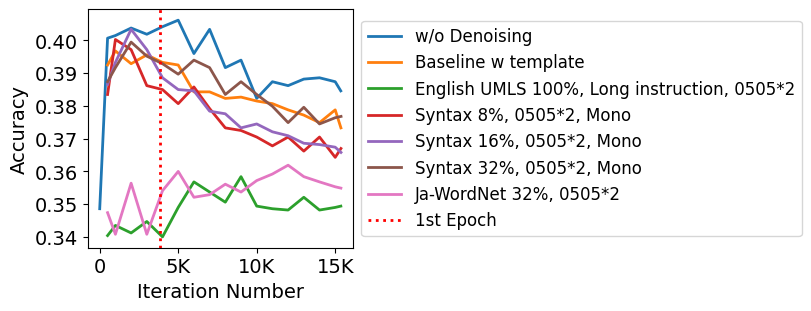

In [4]:
plot_acc_merged("gen", "AdaXEval-Ja", "ja")

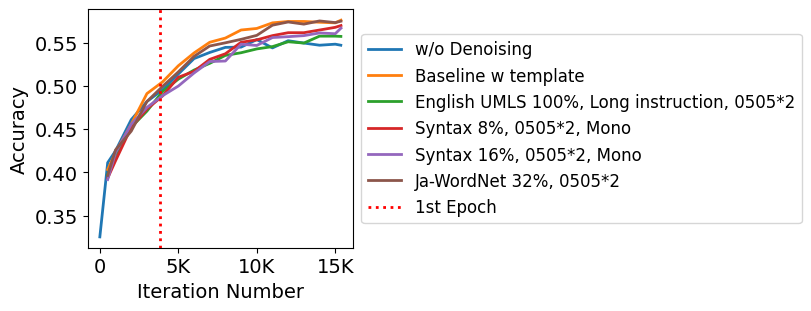

In [11]:
plot_acc_merged("gen", "AdaXEval-En", "en")

In [12]:
sdf = df[(df['iter_num'] > 15000) & (df['eval_type'] == 'gen')]

In [13]:
for model in sdf['model_name'].unique():
    print(model)
    _sdf = sdf[sdf['model_name'] == model]
    print('{:.2%}'.format(_sdf[_sdf['eval_lang'] == 'en']['acc'].tolist()[0]))
    print('{:.2%}'.format(_sdf[_sdf['eval_lang'] == 'ja']['acc'].tolist()[0]))


w/o Denoising
54.73%
38.46%
Baseline w template
57.63%
37.33%
English UMLS 100%, Long instruction, 0505*2
55.75%
34.94%
Syntax 8%, 0505*2, Mono
57.01%
36.70%
Syntax 16%, 0505*2, Mono
56.71%
36.58%
Ja-WordNet 32%, 0505*2
57.51%
35.49%
